Tâche 1: Collecte des données

In [1]:
import os
import json
import requests
from dotenv import load_dotenv
import shutil
from PIL import Image
from PIL.ExifTags import TAGS

# 1. Chargement des variables d'environnement
load_dotenv('.env.local')
ACCESS_KEY = os.getenv('ACCESS_KEY')

METADATA_PATH = "data/images_metadata.json"

def download_metadata(path, url):
    """Enregistre les métadonnées de l'image dans data/images_metadata.json."""
    os.makedirs("data", exist_ok=True)

    # Charger les métadonnées existantes ou initialiser une liste vide
    if os.path.exists(METADATA_PATH):
        with open(METADATA_PATH, "r", encoding="utf-8") as f:
            metadata_list = json.load(f)
    else:
        metadata_list = []

    filename = os.path.basename(path)
    file_size_kb = round(os.path.getsize(path) / 1024, 2)

    # Dimensions et format avec PIL
    try:
        with Image.open(path) as img:
            width, height = img.size
            file_format = img.format or os.path.splitext(filename)[1].lstrip(".").upper()
            exif_data = {}
            if hasattr(img, "getexif") and img.getexif():
                for tag_id, value in img.getexif().items():
                    tag_name = TAGS.get(tag_id, tag_id)
                    try:
                        exif_data[str(tag_name)] = str(value)
                    except (TypeError, ValueError):
                        pass
    except Exception:
        width, height = None, None
        file_format = os.path.splitext(filename)[1].lstrip(".").upper()
        exif_data = {}

    entry = {
        "nom_fichier": filename,
        "dimensions": {"largeur": width, "hauteur": height},
        "format_fichier": file_format,
        "taille_ko": file_size_kb,
        "url_source": url,
        "informations_licence": "Non spécifié",
        "exif": exif_data if exif_data else None,
    }
    metadata_list.append(entry)

    with open(METADATA_PATH, "w", encoding="utf-8") as f:
        json.dump(metadata_list, f, ensure_ascii=False, indent=2)

def download_image(url, i):
    # 1. Créer le dossier 'images' s'il n'existe pas déjà
    os.makedirs("images", exist_ok=True)

    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    
    if request.status_code == 200:
        # 2. Nettoyer le nom du fichier (avant le '?') et ajouter .jpg
        filename = str(i) + ".jpg"
        
        # 3. Créer le chemin complet vers le dossier images
        filepath = os.path.join("images", filename)
        
        with open(filepath, "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)

        download_metadata(filepath, url)
            
    return request.status_code
        
def fetch_100_random_photos(query):
    url = "https://api.unsplash.com/search/photos"
    headers = {
        "Authorization": f"Client-ID {ACCESS_KEY}"
    }
    
    total_needed = 100
    page = 1
    per_page = 10
    
    print(f"Début de la récupération de {total_needed} photos...")

    for i in range(page):
        params = {
            "query": query,
            "page": page,
            "per_page": per_page,
            "orientation": "landscape"
        }

        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status() # Lève une erreur si la requête échoue
        
        photos_data = response.json()["results"]
        
        for idx, photo in enumerate(photos_data):
            # On récupère l'URL 'regular' (ou 'full' selon tes besoins)
            photo_url = photo['urls']['regular']
            download_image(photo_url, idx)
            
        print(f"Progression : {(i+1)*per_page}/{page*per_page}")

    print("Opération terminée.")

if __name__ == "__main__":
    query = input("Quel mot clef voulez vous utiliser pour chercher vos photos")
    fetch_100_random_photos(query)

Début de la récupération de 100 photos...
Progression : 10/10
Opération terminée.


Tâche 2: Étiquetage et annotation

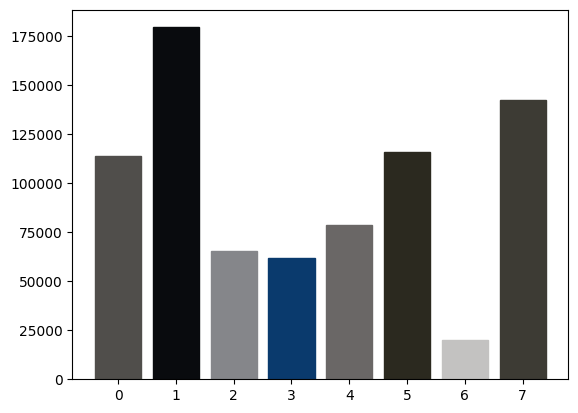

In [6]:
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
from sklearn.cluster import KMeans

def show_hist_kmean(path, n_clusters, n_init):
    imgfile = Image.open(path)
    numarray = numpy.array(imgfile.get_flattened_data(), numpy.uint8)
    clusters = KMeans(n_clusters=n_clusters, n_init=n_init)
    clusters.fit(numarray)
    npbins = numpy.arange(0, n_clusters+1)
    histogram = numpy.histogram(clusters.labels_, bins=npbins)
    labels = numpy.unique(clusters.labels_)
    barlist = plot.bar(labels, histogram[0])
    for i in range(n_clusters):
        barlist[i].set_color(
            "#%02x%02x%02x"
            % (
                math.ceil(clusters.cluster_centers_[i][0]),
                math.ceil(clusters.cluster_centers_[i][1]),
                math.ceil(clusters.cluster_centers_[i][2]),
            )
        )
    plot.show()

show_hist_kmean("images/photo-1727373492036-317e8859152e.jpg", 8, 2)

